## Spam Email Classifier with KNN using TF-IDF scores

1.   Assignment must be implemented in Python 3 only.
2.   You are allowed to use libraries for data preprocessing (numpy, pandas, nltk etc) and for evaluation metrics, data visualization (matplotlib etc.).
3.   You will be evaluated not just on the overall performance of the model and also on the experimentation with hyper parameters, data prepossessing techniques etc.
4.   The report file must be a well documented jupyter notebook, explaining the experiments you have performed, evaluation metrics and corresponding code. The code must run and be able to reproduce the accuracies, figures/graphs etc.
5.   For all the questions, you must create a train-validation data split and test the hyperparameter tuning on the validation set. Your jupyter notebook must reflect the same.
6.   Strict plagiarism checking will be done. An F will be awarded for plagiarism.

**Task: Given an email, classify it as spam or ham**

Given input text file ("emails.txt") containing 5572 email messages, with each row having its corresponding label (spam/ham) attached to it.

This task also requires basic pre-processing of text (like removing stopwords, stemming/lemmatizing, replacing email_address with 'email-tag', etc..).

You are required to find the tf-idf scores for the given data and use them to perform KNN using Cosine Similarity.

### Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from math import sqrt
import nltk
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import r2_score
import time
from numpy.linalg import norm
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import f1_score
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

### Load dataset

In [2]:
df = pd.read_csv('emails.txt', header = None, delimiter = "\t")
df.columns = ['Label', 'Message']
df['Label'] = df['Label'].apply(lambda x:1 if x == "spam" else 0)
df

,Label,Message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...
5568,0,Will ü b going to esplanade fr home?
5569,0,"Pity, * was in mood for that. So...any other s..."
5570,0,The guy did some bitching but I acted like i'd...


### Preprocess data

In [3]:
def preprocess():
  nltk.download('stopwords')
  for i in range(0,len(df)):
    msg = re.sub('[^a-zA-Z]',' ', df['Message'][i])
    msg = msg.lower()
    msg = msg.split()
    ps = PorterStemmer()
    msg = [ps.stem(word) for word in msg if not word in set(stopwords.words('english'))]
    msg = ' '.join(msg)
    df['Message'][i] = msg    

preprocess()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


### Create TF-IDF vectorizer

In [4]:
corpus = []
set_of_words = []

for line in df['Message']:
    corpus.append(line)
    for word in line.split():
        if word not in set_of_words:
            set_of_words.append(word)
        
set_of_words = set(set_of_words)
no_of_documents = len(corpus)
 
dict_of_indexes = {}
i = 0
for word in set_of_words:
    dict_of_indexes[word] = i
    i += 1
    
def count_dict(corpus):
    count_of_words = {}
    for word in set_of_words:
        count_of_words[word] = 0
        for line in corpus:
            if word in line:
                count_of_words[word] += 1
    return count_of_words
 
count_of_words = count_dict(corpus)

def term_freq(word, line):
    s = line.split()
    l = len(s)
    count = 0
    for i in line.split():
        if i==word:
            count = count +1
    if l==0:
        return 0
    return count/l

def inverse_doc_freq(word):
    if word in count_of_words:
        return np.log(no_of_documents)/(count_of_words[word]+1)
    else:
        return np.log(no_of_documents)
    
def tf_idf(sentence):
    tf_idf_vec = np.zeros((len(set_of_words),))
    for word in sentence.split():
        tf = term_freq(word,sentence)
        # print(tf)
        idf = inverse_doc_freq(word)
        # print(idf)
        value = tf*idf
        tf_idf_vec[dict_of_indexes[word]] = value 
    return tf_idf_vec


tf_idf_vec = []
for sentence in corpus:
    vector = tf_idf(sentence)
    tf_idf_vec.append(vector)

### Split data

In [5]:
X_train,X_test,y_train,y_test = train_test_split(tf_idf_vec, df['Label'],test_size=0.25, random_state = 0)

### Train your KNN model (reuse previously iplemented model built from scratch) and test on your data

***1. Experiment with different distance measures [Euclidean distance, Manhattan distance, Hamming Distance] and compare with the Cosine Similarity distance results.***

In [6]:
# dist == 1 -> Euclidean Distance
# dist == 2 -> Manhattan Distance
# dist == 3 -> Cosine Distance

def calc_distance(v1,v2,dist):
  if dist == 1:
    return (np.sqrt(np.sum(np.square(v1-v2))))
  if dist == 2:
    return (np.sum(np.abs(v1-v2)))
  if dist == 3:
    return (1 - np.dot(v1, v2)/(norm(v1)*norm(v2)))

In [7]:
def find_distance(X_train, y_train, X_test):

  dist_euc = []
  dist_man = []
  dist_cos = []
  for i in X_test:
    distance1 = []
    distance2 = []
    distance3 = []
    for j,l in zip(X_train,y_train):
      d1 = calc_distance(i,j,1)
      d2 = calc_distance(i,j,2)
      d3 = calc_distance(i,j,3)
      distance1.append([d1,l])
      distance2.append([d2,l])
      distance3.append([d3,l])
    distance1.sort()
    distance2.sort()
    distance3.sort()
    distance1 = distance1[:100]    
    distance2 = distance2[:100]    
    distance3 = distance3[:100]
    dist_euc.append(distance1)
    dist_man.append(distance2) 
    dist_cos.append(distance3) 

  return dist_euc, dist_man, dist_cos

In [8]:
dist_euc, dist_man, dist_cos = find_distance(X_train, y_train, X_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()


In [9]:
def pred(distance):
  one = 0
  zero = 0
  for label in distance:
    if label[1]==1:
      one = one +1
    else:
      zero = zero+1
  if one>=zero:
    return 1
  else:
    return 0

In [10]:
def knn_prediction(k,dist):
  y_pred = []
  dist_mat = []
  if dist==1:
    dist_mat = dist_euc
  if dist==2:
    dist_mat = dist_man
  if dist == 3:
    dist_mat = dist_cos
  for distance in dist_mat:
    y_pred.append(pred(distance[:k]))
  return y_pred

In [11]:
# def knn_pred(X_train,X_test,y_train,y_test, k,dist):
    
#     y_pred = []
#     count = 1
#     for i in X_test:
#       distance = []
#       for j,l in zip(X_train,y_train):
#         d = calc_distance(i,j,dist)
#         distance.append([d,l])
#       distance.sort()
#       distance = distance[:]
#       one = zero = 0
#       y_pred.append(pred(distance))
#     return y_pred

In [12]:
# def f1Score(y_pred,y_test):
#     TP = TN = FP = FN = 0
#     y_temp = y_test.to_list()
#     for i in range(0,len(y_pred)):
#         if y_pred[i] == 1 and y_temp[i] == 1:
#             TP = TP + 1
#         if y_pred[i] == 1 and y_temp[i] == 0:
#             FP = FP + 1
#         if y_pred[i] == 0 and y_temp[i] == 1:
#             FN = FN + 1
#         if y_pred[i] == 0 and y_temp[i] == 0:
#             TN = TN + 1
#     precision = TP / (TP+FP)
#     recall = TP / (TP+FN)
#     f1score = (2 * precision * recall) / (precision + recall)
#     print(precision,recall,f1score)
#     print(TP,TN,FP,FN)

#     return f1score

***2. Explain which distance measure works best and why? Explore the distance measures and weigh their pro and cons in different application settings.***

Cosine Distance gives us better results than euclidean and Manhattan Distance. This is because cosine distance also takes angle into consideration while calculating distance and Euclidean and Manhattan Distance don't accounts for angle between vectors. Cosine Similarity is majorly used in model which involves sentiment Analysis.



***3. For evaluating model, show confusion matrix, accuracy, recall, precision and F1-score. Answer why accuracy alone is not sufficient to evaluate the model. Why we need precision/recall/f1-score. ?***

In [13]:
# ALl the below caluations are for cosine distance
l = [1,3,5,7,11,17,23,28]
for i in l:
  y_pred = knn_prediction(i,3)
  print("For value of K = ", i)
  cv = confusion_matrix(y_test,y_pred)
  print("Confusion matrix = " ,cv)
  print("Accuracy Score = = ",accuracy_score(y_test, y_pred))
  print("Recall = ", recall_score(y_test,y_pred))
  print("Precision = ", precision_score(y_test, y_pred))
  print("F1 Score = ", f1_score(y_test,y_pred))
  print()
  print()

For value of K =  1
Confusion matrix =  [[1169   39]
 [  57  128]]
Accuracy Score = =  0.9310839913854989
Recall =  0.6918918918918919
Precision =  0.7664670658682635
F1 Score =  0.7272727272727273


For value of K =  3
Confusion matrix =  [[1184   24]
 [  53  132]]
Accuracy Score = =  0.9447236180904522
Recall =  0.7135135135135136
Precision =  0.8461538461538461
F1 Score =  0.7741935483870969


For value of K =  5
Confusion matrix =  [[1194   14]
 [  63  122]]
Accuracy Score = =  0.9447236180904522
Recall =  0.6594594594594595
Precision =  0.8970588235294118
F1 Score =  0.7601246105919003


For value of K =  7
Confusion matrix =  [[1196   12]
 [  64  121]]
Accuracy Score = =  0.9454414931801867
Recall =  0.654054054054054
Precision =  0.9097744360902256
F1 Score =  0.761006289308176


For value of K =  11
Confusion matrix =  [[1201    7]
 [  64  121]]
Accuracy Score = =  0.9490308686288585
Recall =  0.654054054054054
Precision =  0.9453125
F1 Score =  0.7731629392971247


For value o

**Confusion Matrix** 
A confusion matrix is a 2*2 matrix which is used to describe the performance of a classification model on a set of test data for which the true values are known. It have four entries namely True Positive (TP), True Negative(TN), False Positive(FP) and False Negative(FN).

**Accuracy** -
Accuracy of any binary classifier is calculated as sum of TP and TN divide by total number of points. Ideal value of accuracy is 1. Value of accuracy ranges between 0 to 1. Accuracy can be used for evaluation when the data is evenly distributed.But generally the data we get is very  unevenly distributed. As we can see in given dataset almost 85% mails are hams, and remaining emails are spams. If our model fails to predict the spams then due to unbalanced nature of our data accuracy cannot be used for evaluating the correctness of our model. 

**Precision** -
Precision Score tells us what proportion of positive identifications were actually correct.

**Recall** - 
Recall Score tells us how many actual positives were identified correctly.

**F1 Score** -
F1 which is a function of Precision and Recall.F1 Score is needed when you want to seek a balance between Precision and Recall. F1 Score might be a better measure to use if we need to seek a balance between Precision and Recall and  there is an uneven class distribution.

***4. Choose different K values (k=1,3,5,7,11,17,23,28) and experiment. Plot a graph showing F1 score vs k.***

##### Euclidean Distance - Plot of k vs F1 score when euclidean distance is used to calculate distance between 2 vectors.

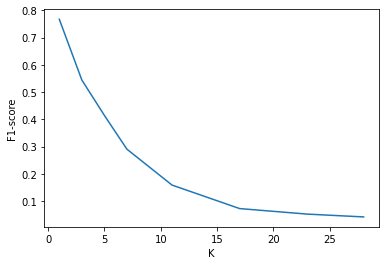

In [14]:
l = [1,3,5,7,11,17,23,28]
fscore = []
for i in l:
  y_pred = knn_prediction(i,1)
  # cv = confusion_matrix(y_test,y_pred)
  # print(cv)
  fscore.append(f1_score(y_test,y_pred))
plt.plot(l, fscore)
plt.xlabel('K')
plt.ylabel('F1-score')
plt.show()


##### Manhattan Distance - Plot of K vs F1 score when manhattan distance is used to calculate distance between 2 vectors.

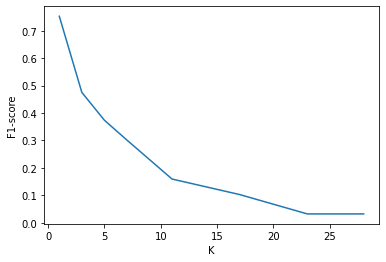

In [15]:
l = [1,3,5,7,11,17,23,28]
fscore = []
for i in l:
  y_pred = knn_prediction(i,2)
  # cv = confusion_matrix(y_test,y_pred)
  # print(cv)
  fscore.append(f1_score(y_test,y_pred))
 
plt.plot(l, fscore)
plt.xlabel('K')
plt.ylabel('F1-score')
plt.show()

##### Cosine Distance - Plot of K vs F1 score when Cosine Distance is used to calculate distance between 2 vectors.

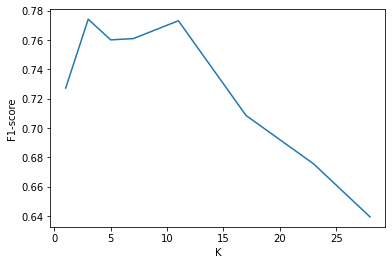

In [16]:
l = [1,3,5,7,11,17,23,28]
fscore = []
for i in l:
  y_pred = knn_prediction(i,3)
  # cv = confusion_matrix(y_test,y_pred)
  # print(cv)
  fscore.append(f1_score(y_test,y_pred))
  
  
plt.plot(l, fscore)
plt.xlabel('K')
plt.ylabel('F1-score')
plt.show()

### Train and test Sklearn's KNN classifier model on your data (use metric which gave best results on your experimentation with built-from-scratch model.)

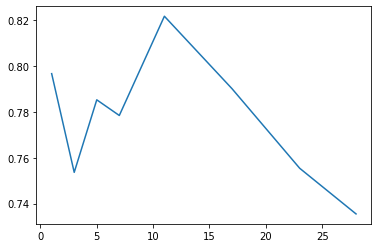

In [17]:
fscore = []
l = [1,3,5,7,11,17,23,28]
for i in l:
    knn = KNeighborsClassifier(n_neighbors=i, metric = "cosine")
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    fscore.append(f1_score(y_test,y_pred))
    # print(accuracy_score(y_test, y_pred))

plt.plot(l,fscore)
plt.show()

***Compare both the models result.***

If we compare both the knn models i.e. the one made from scratch and one made using sklearn library both gives maximum f1_score at k = 11 which is 0.77 for vanilla knn and 0.82 for sklearn knn. The nature of the graph between K and F1 score for both the KNNs is almost same with minor inaccuracies in vanilla knn model. As the value of k increase from 11 to 28 the f1_score for the model decreases gradually which signfies then at k=11 the model will give the best results.

***What is the time complexity of training using KNN classifier?***

The time complexity for training a KNN classifier is **O(1)**  i.e. constant. This is because knn classifier just store values of training points as a vector and do not do any kind of processing.

***What is the time complexity while testing? Is KNN a linear classifier or can it learn any boundary?***

The time complexity for testing a single point in KNN classifier is **O(n*d)** where **n** is no. of training points available in the dataset and **d** is no. of dimensions of a vector. At the time of testing knn classifier calculates the distance between all the training points and the test point and return k points with least distance from the test point. Calculating distance takes **O(d)** time where d is dimension of the vector. 

The decision boundaries of knn are locally linear segments but in general they have more complex shape which is not equivalent to line in 2-D or hyperplane in higher dimesions.